Nome: Mateus Henrique Silva Araújo

RA: 184940

Curso: Engenharia de Computação



# Ex06 - Desafio de classificação: detecção de tumores no cérebro

O objetivo deste desafio é classificar um conjunto de imagens 2D de cérebros saudáveis e cérebros contendo tumores. As imagens estão no diretório **Dados/Ex06/Brain_Tumor_Dataset**, subdivididas em conjuntos de treino, validação e teste. Note que as labels do conjunto de teste não estão disponíveis!

Sinta-se livre para utilizar qualquer classificador/técnica que desejar, mas lembre-se de justificar suas escolhas! A ideia é que você tente utilizar tudo que foi aprendido até aqui para obter um classificador com o melhor desempenho possível. Após definir o seu modelo final, você deve obter as predições para o conjunto de teste. Assim, além deste notebook com seus experimentos e comentários, você deve enviar também um arquivo com as suas predições para o conjunto de teste. Nas instruções do exercício no classroom você vai encontrar informações mais específicas sobre como enviar suas predições para o conjunto de teste.

**ATENÇÃO**: a nota deste exercício não vai se basear no desempenho final do seu classificador! Mais detalhes sobre os critérios de avaliação serão postados no classroom em breve.

Sugestões:
- Aplique técnicas de data augmentation;
- Tente utilizar modelos pré-treinados e técnicas de transfer learning;
- Tente modificar os hiperparâmetros (Optimizer, Learning-Rate, Número de Épocas, Tamanho do Batch, etc) para obter modelos com melhor desempenho;
- Utilize alguma ferramenta para acompanhamento e visualização das curvas de treino e validação (loss e acurácia). Por ex.: [Neptune](https://neptune.ai) ou [Wandb](https://wandb.ai/). Compare as diferentes versões de modelos utilizadas.

# Resolução:

In [1]:
# Importando as bibliotecas que serão utilizadas
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import datasets, models
from torchvision.transforms import v2
from torchvision.utils import make_grid
from torchmetrics import Accuracy
import torchinfo
from torchsummary import summary
import multiprocessing as mp
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

### Definições de Datasets, transformações de data augmentation e DataModule:

Primeiramente, vamos definir os datasets e a classe de datamodule usado no experimento. Além disso, convém avaliar as características das imagens tratadas.

In [2]:
# Definindo caminhos para pastas com dados
train_data_path = "Brain_Tumor_Dataset/train"
val_data_path = "Brain_Tumor_Dataset/val"
test_data_path = "Brain_Tumor_Dataset/test"

train_dataset = datasets.ImageFolder(root=train_data_path,transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
val_dataset   = datasets.ImageFolder(root=val_data_path,transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
test_dataset  = datasets.ImageFolder(root=test_data_path,transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))

# Definição do DataModule
class BrainTumor_DataModule(pl.LightningDataModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)  # Salva hiperparâmetros

    def setup(self, stage=None):
        self.train  = train_dataset         # Salva dataset de treino
        self.val    = val_dataset           # Salva dataset de validação
        self.test   = test_dataset          # Salva dataset de teste

    '''
    Dataloaders optimize data loading and automatically prepare batches
    '''
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=False)

    def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.hparams.batch_size, num_workers=self.hparams.nworkers, shuffle=False)

print(train_dataset)
print()
print(val_dataset)
print()
print(test_dataset)


Dataset ImageFolder
    Number of datapoints: 143
    Root location: Brain_Tumor_Dataset/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

Dataset ImageFolder
    Number of datapoints: 62
    Root location: Brain_Tumor_Dataset/val
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

Dataset ImageFolder
    Number of datapoints: 48
    Root location: Brain_Tumor_Dataset/test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )


Com os datasets iniciais definidos acima, podemos iterar pelas imagens e verificar seu número de canais e tamanho  

In [ ]:
print('Exemplares de treinamento:')
for i in range(0,5):
    img , label = random.choice(train_dataset)
    print(img.shape)
print()
print('Exemplares de validação:')
for i in range(0,5):
    img , label = random.choice(val_dataset)
    print(img.shape)

Acima, podemos ver que as imagens exemplares obtidas apresentam dimensões diferentes entre si. Também observamos que, mesmo sendo imagens que aparentar ter somente uma cor, elas possuem três canais. Ao iterar sobre todo o conjunto de dados e validação, vemos que todas imagens apresentam estas características. Dessa forma, consiste em uma decisão de projeto escolher um tamanho para redimensionar todas as imagens, de modo a padronizar o tamanho da entrada da rede.  
Nesse sentido, decidi por fazer uma varredura sobre todas as imagens de treinamento para calcular os valores máximos, mínimo e médios de dimensões

In [ ]:
acc_h = 0
acc_w = 0
num = 0
max_h = train_dataset[0][0].shape[1]
min_h = train_dataset[0][0].shape[1]
max_w = train_dataset[0][0].shape[2]
min_w = train_dataset[0][0].shape[2]

for i in train_dataset:
    dim_h = i[0].shape[1]
    dim_w = i[0].shape[2]

    if dim_h > max_h:
        max_h = dim_h
    if dim_h < min_h:
        min_h = dim_h

    if dim_w > max_w:
        max_w = dim_w
    if dim_w < min_w:
        min_w = dim_w

    acc_h += dim_h
    acc_w += dim_w
    num +=1

med_h = acc_h/num
med_w = acc_w/num
print(f'Dimensões:\n\
        \tMax H = {max_h}\t\tMax W = {max_w}\n\
        \tMed H = {med_h:.1f}\t\tMed W = {med_w:.1f}\n\
        \tMin H = {min_h}\t\tMin W = {min_w}\n')

hs = np.zeros(max_h-min_h+1)
ws = np.zeros(max_w-min_w+1)
for i in train_dataset:
    hs[i[0].shape[1]-168]+=1
    ws[i[0].shape[2]-150]+=1

print(f'Dimensão H com maior número de elementos: {np.argmax(hs)+min_h}')
print(f'Dimensão W com maior número de elementos: {np.argmax(hs)+min_w}')

Acima, vemos que temos valores bem distantes de máximos e mínimos para cada dimensão. Portanto, como downscaling pode auxiliar na eliminação de ruído e um upscaling muito elevado pode acabar gerando ruído, imagino seja adequado redimensionar as imagens para dimensões próximas às mais comuns. Dessa forma, vou optar por redimensionar as imagens para tamanho 200x200. Com essa decisão tomada, podemos definir as transformações de pré-processamento que serão aplicadas aos dados.

In [3]:
# Definindo transformações de pré-processamento
data_aug_transforms = v2.Compose([
    v2.RandomApply(transforms=[v2.RandomRotation(degrees=(-45,45))],p=0.4),  # Rotaciona a imagem em até noventa graus com 30% de ocorrer
    v2.RandomAdjustSharpness(sharpness_factor=2,p=0.3),                      # Aleatoriamente ajusta a nitidez da imagem com
    v2.RandomHorizontalFlip(0.5),                                            # Gira a imagem horizontalmente com 50% de chance de ocorrer
    v2.RandomAutocontrast(p=0.3),                                            # Faz autocontraste com 30% de ocorrer
    v2.RandomEqualize(p=0.25),                                               # Aleatoriamente equaliza o histograma da imagem com 25% de ocorrer
    v2.RandomApply(transforms=[v2.GaussianBlur(kernel_size=(5,5))],p=0.4),   # Borra a imagem com filtro gaussiano com 20% de chance de ocorrer
])

preprocess_transforms = v2.Compose([
    v2.Resize(size=(200,200)),                                               # Altera o tamanho das imagens para um padrão                                                                              
    v2.ToImage(),                                   #
    v2.ToDtype(torch.float32, scale=True),          # Transforma a imagem em um tensor (v2.toTensor() está decriptado)
])

# Redefinindo o datasets para realizar transformações necessárias
train_dataset = datasets.ImageFolder(root=train_data_path,transform=v2.Compose([data_aug_transforms,preprocess_transforms])) # Data augmentation aplicado só no treino
val_dataset   = datasets.ImageFolder(root=val_data_path,transform=preprocess_transforms)
test_dataset  = datasets.ImageFolder(root=test_data_path,transform=preprocess_transforms)

Para finalizar a seção de preparação dos dados, podemos avaliar os loaders da classe datamodule antes definida agora com as transformações de pré-processamento configuradas.

Shape do batch: torch.Size([5, 3, 200, 200])


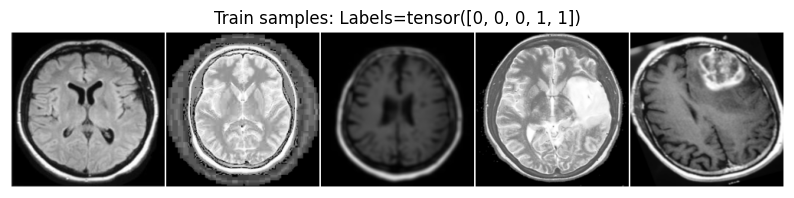

Shape do batch: torch.Size([5, 3, 200, 200])


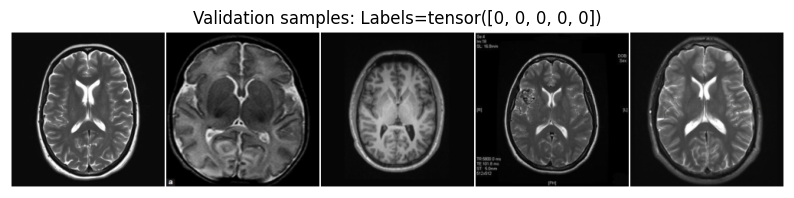

In [17]:
hparams0 = {"experiment_name": "datamodule_test",  # experiment name identifies the run for later
           "max_epochs": 100,                      # number of epochs to train
           "batch_size": 5,                        # size of batch
           "nworkers": mp.cpu_count(),             # number of workers to use in parallel loading
           "nout": 2,                              # number of classes
           "nin": 3,                               # number of channels of the input image
           "lr": 1e-4,                             # learning rate
           "wd": 1e-5,                             # weight decay for optimizer
           "cpu": False,                           # forces using the CPU
           }

# Verificando informações do DataModule definido
data_module = BrainTumor_DataModule(hparams0)                # Instânciando DataModule
data_module.setup()   # Configurando DataModule

dataloader = data_module.train_dataloader()                   # Obtendo data loader de treino
img_batch, label_batch = next(iter(dataloader))               # Obtendo primeiro batch e seus labels
print("Shape do batch:", img_batch.shape)                     # Imprimindo informações de batch

img_grid = make_grid(img_batch, nrow=5, pad_value=1)         # Gerando grade com batch
fig = plt.figure(figsize=(10,10))
plt.imshow(img_grid.permute(1, 2, 0).numpy())
plt.title(f'Train samples: Labels={label_batch}')
plt.axis('off')
plt.show()

dataloader = data_module.val_dataloader()
img_batch, label_batch = next(iter(dataloader))
print("Shape do batch:", img_batch.shape)

img_grid = make_grid(img_batch, nrow=5, pad_value=1)
fig = plt.figure(figsize=(10,10))
plt.imshow(img_grid.permute(1, 2, 0).numpy())
plt.title(f'Validation samples: Labels={label_batch}')
plt.axis('off')
plt.show()



### Definição da CNN:

Primeiramente, vale destacar que temos um problema de classificação, dessa forma precisaremos de uma rende convolucional especializa em segmentação. Para tal, observando o gráfico de desempenhos das diferentes arquiteturas em função de sua complexidade, acredito que as principais candidatas à essa tarefa são as redes: Inception-v3, Resnet-101(152) e EfficientNet (v2). O motivo de elas serem candidatas é que todas as três apresentam uma elevada acurácia e estão disponíveis nativamente na biblioteca do pytorch. A principal diferença observada entre elas é a quantidade total de parâmetros de cada uma e sua complexidade geral (número de camadas, complexidade de processamento, etc). Dessa forma, iniciarei trabalhando sobre a rede  EfficientNet v2 por ser mais recente, apresentar uma proposta de eficiência computacional e uma elevada acurácia para classificação top 1.

In [4]:
# Definindo a CNN.
cnn_model = models.efficientnet_v2_l(weights=None)

# Configurando GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# A rede por padrão recebe imagens de 3 canais e retorna 1000 classes. Como nossas imagens também tem três canais, precisamos
# alterar a última camada para que somente duas classes sejam produzidas
cnn_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)    # Alterando última camada para gerar 2 classes
cnn_model.to(device)                                                                # Colocando a rede nad GPU

# Imprimindo resumo da rede final
summary(cnn_model, (3, 200, 200))                                                     

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             864
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              SiLU-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 32, 100, 100]           9,216
       BatchNorm2d-5         [-1, 32, 100, 100]              64
              SiLU-6         [-1, 32, 100, 100]               0
   StochasticDepth-7         [-1, 32, 100, 100]               0
       FusedMBConv-8         [-1, 32, 100, 100]               0
            Conv2d-9         [-1, 32, 100, 100]           9,216
      BatchNorm2d-10         [-1, 32, 100, 100]              64
             SiLU-11         [-1, 32, 100, 100]               0
  StochasticDepth-12         [-1, 32, 100, 100]               0
      FusedMBConv-13         [-1, 32, 100, 100]               0
           Conv2d-14         [-1, 32, 1

### Definindo classe e função de treinamento:

Vamos manter a função de perda como sendo `CrossEntropyLoss` e função de otimização como sendo `AdamW` para verificar versões iniciais da rede.

In [5]:
# Definição do processo de treinamento
class Train_BrainTumor(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.model = cnn_model
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.hparams.nout)
        torchinfo.summary(self.model)

    def forward(self, x):
        return self.model(x).softmax(dim=-1)

    def classification_step(self, mode, batch):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)

        if mode == "train":
            self.log("loss", loss, on_epoch=True, on_step=True)
            return loss
        elif mode == "val":
            _, preds = torch.max(y_hat, 1)
            self.accuracy(preds, y)
            self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
            self.log("val_acc", self.accuracy, on_epoch=True, on_step=False, prog_bar=True)

    def training_step(self, train_batch, batch_idx):
        return self.classification_step("train", train_batch)

    def validation_step(self, val_batch, batch_idx):
        self.classification_step("val", val_batch)

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)

        return optimizer

In [6]:
def exec_training(hparams):
    model = Train_BrainTumor(hparams)          # Inicializando modelo de treinamento
    data  = BrainTumor_DataModule(hparams)      # Inicializando módulo de dados

    checkpoint_callback = [ModelCheckpoint(dirpath='logs',  # Configurando salvamento de checkpoints
                                        filename=hparams["experiment_name"] + "-{epoch}-{val_acc:.2f}",
                                        monitor="val_acc",
                                        mode="max")]

    # Configurando módulo treinador
    trainer = pl.Trainer(max_epochs=hparams["max_epochs"],           # Número máximo de épocas
                        fast_dev_run=False,                          # Função de debbug
                        callbacks=checkpoint_callback,               # Configurando callback para guardar checkpoints
                        log_every_n_steps=1,                         # Configurando passo para fazer log de progresso
                        )

    # Imprimindo hiperparâmetros
    print("\nHyperparameters:\n{")
    for k, v in hparams.items():
        print(f'{k}: {v}')
    print('}\n')

    # Treinando modelo
    trainer.fit(model, data)
    return

### Definindo funções para avaliação de versão de rede:

In [7]:
# Essa função importa o modelo salvo em um checkpoint, carrega os dados de validação e verifica seu desempenho
def display_results(hparams):
    filename = hparams['experiment_name']
    baseline_model =  glob(f"logs/*{ filename }*.ckpt")[0]
    print(f"Using model {baseline_model}")

    model = Train_BrainTumor.load_from_checkpoint(baseline_model).eval().cuda()

    data = BrainTumor_DataModule(hparams)
    data.setup()
    data.hparams.batch_size = 1
    data = data.val_dataloader()

    y_trues = []
    y_labels = []
    
    for (img, label) in data:
        with torch.no_grad():
            out = model(img.cuda()).argmax(dim=-1).item()

        label = label.numpy()
        y_trues.append(label)
        y_labels.append(out)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_trues, y_labels, labels=np.arange(2)),
                                    display_labels=np.arange(2))
    fig = disp.plot(ax=None).figure_
    plt.show()
    acc = accuracy_score(y_trues, y_labels)
    prec = precision_score(y_trues, y_labels)
    rec = recall_score(y_trues, y_labels)
    f1 = f1_score(y_trues, y_labels)
    
    # Imprimindo as métricas
    print('Acurácia: %.2f' % acc)
    print('Precisão: %.2f' % prec)
    print('Recall: %.2f' % rec)
    print('F1-Score: %.2f' % f1)
    return


### Versão 1:

Definição de hiperparâmetros da primeira versão:

In [8]:
# Hiperparâmetros
hparams1 = {"experiment_name": "Brain_Tumor_EfficientNet_v1",  # experiment name identifies the run for later
           "max_epochs": 100,                                  # number of epochs to train
           "batch_size": 5,                                    # size of batch
           "nworkers": mp.cpu_count(),                         # number of workers to use in parallel loading
           "nout": 2,                                          # number of classes
           "nin": 3,                                           # number of channels of the input image
           "lr": 1e-4,                                         # learning rate
           "wd": 1e-5,                                         # weight decay for optimizer
           "cpu": False,                                       # forces using the CPU
           }

Treinamento da rede:

In [ ]:
exec_training(hparams1)

Verificação de desempenho:

Using model logs\Brain_Tumor_EfficientNet_v1-epoch=84-val_acc=0.81.ckpt


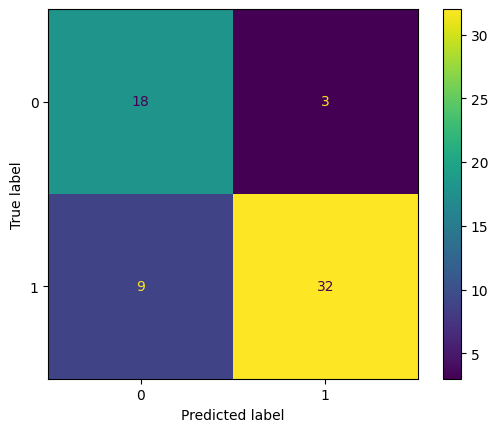

Acurácia: 0.81
Precisão: 0.91
Recall: 0.78
F1-Score: 0.84


In [56]:
display_results(hparams1)

### Versão 2:

Nessa versão, vamos avaliar os efeitos de adicionar uma transformação de pré-processamento para passar todos os dados para escala de cinza (de 1 canal).

In [9]:
preprocess_transforms = v2.Compose([v2.Grayscale(1),preprocess_transforms])

# Redefinindo o datasets para inserir nova transformação
train_dataset = datasets.ImageFolder(root=train_data_path,transform=v2.Compose([data_aug_transforms,preprocess_transforms])) # Data augmentation aplicado só no treino
val_dataset   = datasets.ImageFolder(root=val_data_path,transform=preprocess_transforms)
test_dataset  = datasets.ImageFolder(root=test_data_path,transform=preprocess_transforms)

# Redefinindo rede para adequar parâmetros de entrada
cnn_model = models.efficientnet_v2_l(weights=None)

# Configurando GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# A rede por padrão recebe imagens de 3 canais e retorna 1000 classes. Como nossas imagens agora tem 1 canal, precisamos
# alterar a última camada para que somente duas classes sejam produzidas e a primeira para receber uma entrada de 1 canal
cnn_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
cnn_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)    # Alterando última camada para gerar 2 classes
cnn_model.to(device)                                                                # Colocando a rede nad GPU

# Imprimindo resumo da rede final
summary(cnn_model, (1, 200, 200))      


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             288
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              SiLU-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 32, 100, 100]           9,216
       BatchNorm2d-5         [-1, 32, 100, 100]              64
              SiLU-6         [-1, 32, 100, 100]               0
   StochasticDepth-7         [-1, 32, 100, 100]               0
       FusedMBConv-8         [-1, 32, 100, 100]               0
            Conv2d-9         [-1, 32, 100, 100]           9,216
      BatchNorm2d-10         [-1, 32, 100, 100]              64
             SiLU-11         [-1, 32, 100, 100]               0
  StochasticDepth-12         [-1, 32, 100, 100]               0
      FusedMBConv-13         [-1, 32, 100, 100]               0
           Conv2d-14         [-1, 32, 1

In [10]:
# Hiperparâmetros (mantemos a mesma coisa que o da versão 1, de modo a avaliar somente o efeito da transformação adicional)
hparams2 = {"experiment_name": "Brain_Tumor_EfficientNet_v2",  # experiment name identifies the run for later
           "max_epochs": 100,                                  # number of epochs to train
           "batch_size": 10,                                    # size of batch
           "nworkers": mp.cpu_count(),                         # number of workers to use in parallel loading
           "nout": 2,                                          # number of classes
           "nin": 3,                                           # number of channels of the input image
           "lr": 1e-4,                                         # learning rate
           "wd": 1e-5,                                         # weight decay for optimizer
           "cpu": False,                                       # forces using the CPU
           }

Treinamento:

In [ ]:
exec_training(hparams2)

Verfificação de desempenho:

Using model logs\Brain_Tumor_EfficientNet_v2-epoch=99-val_acc=0.92.ckpt


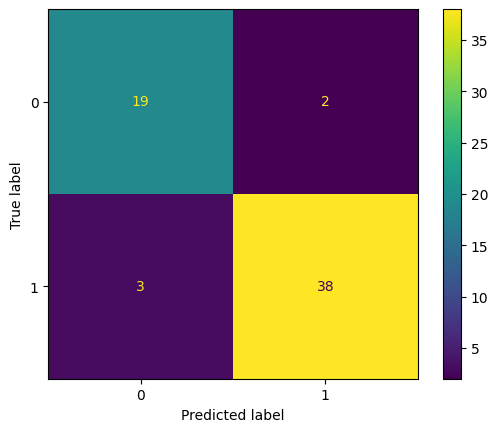

Acurácia: 0.92
Precisão: 0.95
Recall: 0.93
F1-Score: 0.94


In [66]:
display_results(hparams2)

Percebemos uma melhora significativa ao inserir a transformação para escala de cinza como pré-processamento. Vamos mantê-la para as versões seguintes.

### Versão 3:

Como terceira versão, vamos tentar adicionar transfer learning à versão 2 e verificar os efeitos produzidos

In [11]:
# Redefinindo rede
cnn_model = models.efficientnet_v2_l(weights='DEFAULT')

# Configurando GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# A rede por padrão recebe imagens de 3 canais e retorna 1000 classes. Como nossas imagens agora tem 1 canal, precisamos
# alterar a última camada para que somente duas classes sejam produzidas e a primeira para receber uma entrada de 1 canal
cnn_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
cnn_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)    # Alterando última camada para gerar 2 classes
cnn_model.to(device)                                                                # Colocando a rede nad GPU

# Imprimindo resumo da rede final
summary(cnn_model, (1, 200, 200))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             288
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              SiLU-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 32, 100, 100]           9,216
       BatchNorm2d-5         [-1, 32, 100, 100]              64
              SiLU-6         [-1, 32, 100, 100]               0
   StochasticDepth-7         [-1, 32, 100, 100]               0
       FusedMBConv-8         [-1, 32, 100, 100]               0
            Conv2d-9         [-1, 32, 100, 100]           9,216
      BatchNorm2d-10         [-1, 32, 100, 100]              64
             SiLU-11         [-1, 32, 100, 100]               0
  StochasticDepth-12         [-1, 32, 100, 100]               0
      FusedMBConv-13         [-1, 32, 100, 100]               0
           Conv2d-14         [-1, 32, 1

Vamos manter os mesmos hiperparâmetros da versão 2 com intuito de avaliar apenas os efeitos da adição de transfer learning.

In [12]:
# Hiperparâmetros (mantemos a mesma coisa que o da versão 1, de modo a avaliar somente o efeito da transformação adicional)
hparams3 = {"experiment_name": "Brain_Tumor_EfficientNet_v3",  # experiment name identifies the run for later
           "max_epochs": 100,                                  # number of epochs to train
           "batch_size": 5,                                    # size of batch
           "nworkers": mp.cpu_count(),                         # number of workers to use in parallel loading
           "nout": 2,                                          # number of classes
           "nin": 3,                                           # number of channels of the input image
           "lr": 1e-4,                                         # learning rate
           "wd": 1e-5,                                         # weight decay for optimizer
           "cpu": False,                                       # forces using the CPU
           }

Executando treinamento:

In [ ]:
exec_training(hparams3)

Avaliando desempenho:

Using model logs\Brain_Tumor_EfficientNet_v3-epoch=69-val_acc=1.00.ckpt


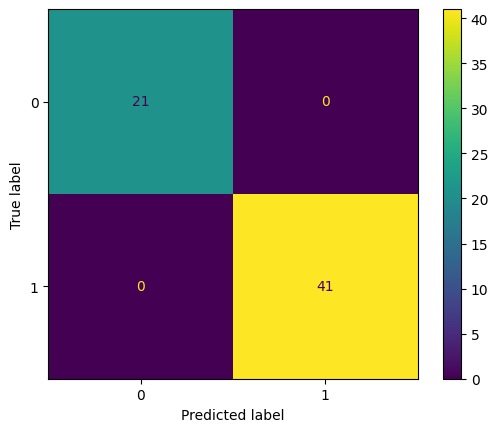

Acurácia: 1.00
Precisão: 1.00
Recall: 1.00
F1-Score: 1.00


In [14]:
display_results(hparams3)

Obtivemos métricas perfeitas como resultado da versão 3. Entretando, muito provavelmente isto aconteceu em virtude da quantidade reduzida de dados de validação ou por que aconteceu um *overfiting*. A hipótese do *overfiting* ganha força ao checarmos os logs e observarmos que o evento de acurácia 1 ocorreu próximo a um pico da função de perda nos dados de treino. Para tentar contornar esse problema, vamos manter o transfer learning, já que ele aparenta ter ajudado, e reduzir o *learning rate*.

### Versão 4:

In [13]:
# Redefinindo rede
cnn_model = models.efficientnet_v2_l(weights='DEFAULT')

# Configurando GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
cnn_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)    # Alterando última camada para gerar 2 classes
cnn_model.to(device)                                                                # Colocando a rede nad GPU

# Hiperparâmetros (mantemos a mesma coisa que o da versão 1, de modo a avaliar somente o efeito da transformação adicional)
hparams4 = {"experiment_name": "Brain_Tumor_EfficientNet_v4",  # experiment name identifies the run for later
           "max_epochs": 100,                                  # number of epochs to train
           "batch_size": 5,                                    # size of batch
           "nworkers": mp.cpu_count(),                         # number of workers to use in parallel loading
           "nout": 2,                                          # number of classes
           "nin": 1,                                           # number of channels of the input image
           "lr": 0.5e-4,                                       # learning rate
           "wd": 1e-5,                                         # weight decay for optimizer
           "cpu": False,                                       # forces using the CPU
           }

Executando treino:

In [ ]:
exec_training(hparams4)

Avaliando desempenho:

Using model logs\Brain_Tumor_EfficientNet_v4-epoch=71-val_acc=0.97.ckpt


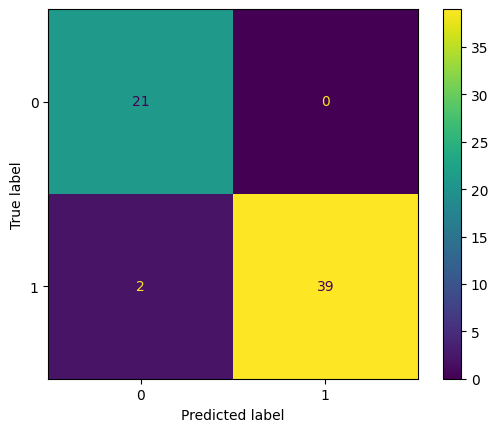

Acurácia: 0.97
Precisão: 1.00
Recall: 0.95
F1-Score: 0.97


In [13]:
display_results(hparams4)

Essa versão produziu novamente uma rede com boas métricas e, dessa vez, sem um pico da função de perda nos dados de treinamento próximo da versão que gerou melhor valor de acurácia.

### Versão 5

Para esta versão, vamos tentar reduzir o número de épocas do treinamento da versão 3, com intuito novamente de evitar possíveis *overfiting*.

In [14]:
# Redefinindo rede
cnn_model = models.efficientnet_v2_l(weights='DEFAULT')

# Configurando GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
cnn_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)    # Alterando última camada para gerar 2 classes
cnn_model.to(device) 

# Hiperparâmetros (versão 3 com menor número de épocas)
hparams5 = {"experiment_name": "Brain_Tumor_EfficientNet_v5",  # experiment name identifies the run for later
           "max_epochs": 60,                                   # number of epochs to train
           "batch_size": 5,                                    # size of batch
           "nworkers": mp.cpu_count(),                         # number of workers to use in parallel loading
           "nout": 2,                                          # number of classes
           "nin": 1,                                           # number of channels of the input image
           "lr": 1e-4,                                         # learning rate
           "wd": 1e-5,                                         # weight decay for optimizer
           "cpu": False,                                       # forces using the CPU
           }

Executando treinamento:

In [ ]:
exec_training(hparams5)

Avaliando desempenho:

Using model logs\Brain_Tumor_EfficientNet_v5-epoch=14-val_acc=0.97.ckpt


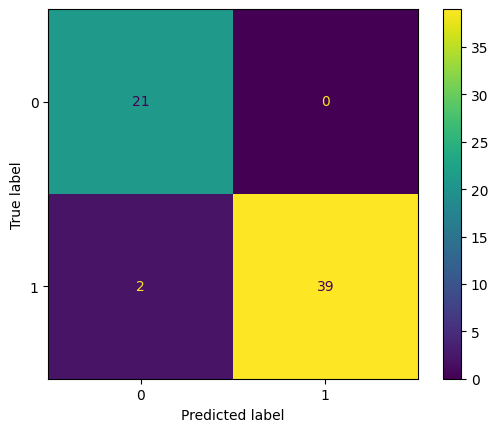

Acurácia: 0.97
Precisão: 1.00
Recall: 0.95
F1-Score: 0.97


In [17]:
display_results(hparams5)

### Versão 6:

As curvas da função de perda no conjunto de validação ainda continua muito ruídosa. Para tentar melhorar isso e, ao mesmo tempo, garantir que não está havendo *overfiting*, temos as seguintes opções:

* Diminuir learning rate ou aumentar batch size para gerar curvas da função de loss na validação e no treino menos ruídosas
* Realizar validação crusada com k-fold para alternar o conjunto de validação e tornar menos provável um overfiting
* Definir um *early stop* para parar as iterações quando a função de perda na validação começar a crescer mesmo com a função de perda no treinamento continuar decaindo

Aparentemente, o `Pytorch` e o módulo `Lightning` não possuem funções nativas para se fazer validação cruzada usando *k-fold*. Então vamos tentar as outras duas opções.

In [15]:
# Redefinindo função de treino para considerar early-stop
def exec_training(hparams):
    model = Train_BrainTumor(hparams)          # Inicializando modelo de treinamento
    data  = BrainTumor_DataModule(hparams)      # Inicializando módulo de dados

    # Configurando callback de checkpoint
    checkpoint_callback = ModelCheckpoint(dirpath='logs',   # Configurando salvamento de checkpoints
                                        filename=hparams["experiment_name"] + "-{epoch}-{val_acc:.2f}--{val_loss:.5f}",
                                        monitor="val_loss", # Como vamos tentar treinar a rede até o mínimo de perda na validação, a métrica de monitoramento
                                        mode="min")
    
    # Configurando callback de early stopping
    earlystop_callback = EarlyStopping( monitor="val_loss", patience = 100, mode="min")

    # Configurando módulo treinador
    trainer = pl.Trainer(max_epochs=hparams["max_epochs"],                  # Número máximo de épocas
                        fast_dev_run=False,                                 # Função de debbug
                        callbacks=[checkpoint_callback,earlystop_callback],  # Configurando callback para guardar checkpoints
                        log_every_n_steps=1,                                # Configurando passo para fazer log de progresso
                        )

    # Imprimindo hiperparâmetros
    print("\nHyperparameters:\n{")
    for k, v in hparams.items():
        print(f'{k}: {v}')
    print('}\n')

    # Treinando modelo
    trainer.fit(model, data)
    return

In [16]:
# Redefinindo rede
cnn_model = models.efficientnet_v2_l(weights='DEFAULT')

# Configurando GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
cnn_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)    # Alterando última camada para gerar 2 classes
cnn_model.to(device) 

# Hiperparâmetros (maior batch size, menor learning rate, número de épocas ao máximo, pois vamos confiar no early-stop)
hparams6 = {"experiment_name": "Brain_Tumor_EfficientNet_v6",  # experiment name identifies the run for later
           "max_epochs": 700,                                  # number of epochs to train
           "batch_size": 5,                                   # size of batch
           "nworkers": mp.cpu_count(),                         # number of workers to use in parallel loading
           "nout": 2,                                          # number of classes
           "nin": 1,                                           # number of channels of the input image
           "lr": 0.25e-4,                                         # learning rate
           "wd": 1e-5,                                         # weight decay for optimizer
           "cpu": False,                                       # forces using the CPU
           }

Executando treinamento:

In [ ]:
exec_training(hparams6)

Como o tempo para a entrega do trabalho está se esgotando, foi necessário interromper o treinamento por volta da época 207. Infelizmente, ainda não foi possível reduzir a oscilação da curva da função de perda do conjunto de validação mesmo com metade do menor learning rate usado até agora. O próximo aprimoramento a ser feito seria aumentar o *batch* e tentar novamente rodar com um número de épocas elevado, mantendo somente aquela com menor valor da função de perda na validação.

Avaliando desempenho:

Using model logs\Brain_Tumor_EfficientNet_v6-epoch=169-val_acc=0.97--val_loss=0.35083.ckpt


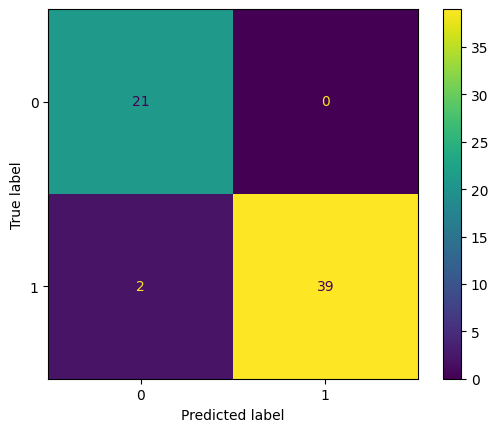

Acurácia: 0.97
Precisão: 1.00
Recall: 0.95
F1-Score: 0.97


In [35]:
display_results(hparams6)

Dado que esta última versão apresenta uma função de perda na validação menor que as demais e, ainda assim, mantém uma boa acurácia, ela será usada como a versão final.

### Teste e produção da saída solicitada:

Carregando checkpoint e dados de teste

In [17]:
filename = hparams6['experiment_name']
baseline_model =  glob(f"logs/*{ filename }*.ckpt")[0]
print(f"Using model {baseline_model}")

model = Train_BrainTumor.load_from_checkpoint(baseline_model).eval().cuda()

data = BrainTumor_DataModule(hparams6)
data.setup()
data.hparams.batch_size = 1
data = data.test_dataloader()

Using model logs\Brain_Tumor_EfficientNet_v6-epoch=169-val_acc=0.97--val_loss=0.35083.ckpt


Gerando arquivo

In [33]:
fd = open(file='Ex06_184940.txt',mode='w',encoding="utf-8")
for i , (img, label) in enumerate(data):
    with torch.no_grad():
        out = model(img.cuda()).argmax(dim=-1).item()
    predict = "health"  if out==0 else "tumor"  
    fd.write(f"{i:0>4}_test {predict}")
    if i < 47: 
        fd.write('\n') 
fd.close()
    